<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-II-Computer-Vision/01_classifying_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Classifying Images

Let’s classify images! Although the data is
different, it is still a classification problem, so we will try to predict which class an
image belongs to.

First, let’s generate some images to work with (so we don’t have to use MNIST!).

##Setup

In [ ]:
try:
  import google.colab
  import requests
  url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
  r = requests.get(url, allow_redirects=True)
  open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
  pass

from config import *
config_chapter4()
# This is needed to render the plots in this chapter
from plots.chapter4 import *

In [2]:
import random
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler, SubsetRandomSampler
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, RandomHorizontalFlip, Resize

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from data_generation.image_classification import generate_dataset
from stepbystep.v0 import StepByStep
from plots.chapter4 import *

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

## Data Generation

Our images are quite simple: They have black backgrounds and white lines drawn
on top of them. The lines can be drawn either in a diagonal or in a parallel way. 

So, our classification
problem can be simply stated as: Is the line diagonal?

If the line is diagonal, then we assume it belongs to the positive class. If it is not
diagonal, it belongs to the negative class.

|Line|Value|Class|
|--|--|--|
|Not Diagonal|0|Negative|
|Diagonal|1|Positive|

Let’s generate 300 random images, each one five-by-five pixels in size.

In [4]:
images, labels = generate_dataset(img_size=5, n_images=300, binary=True, seed=13)

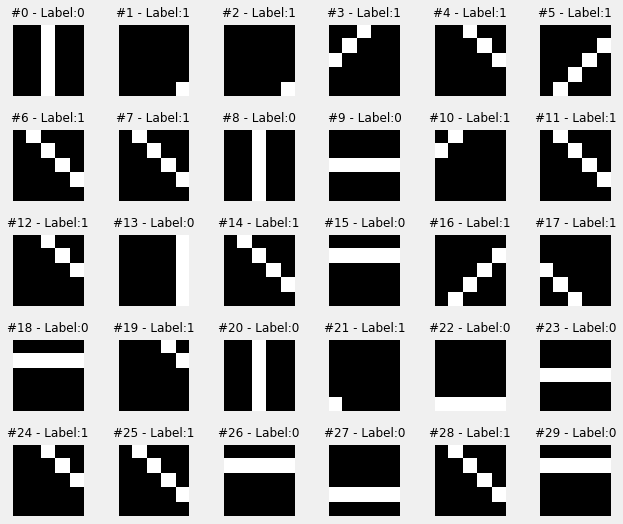

In [5]:
# let’s visualize the first 30 images
fig = plot_images(images, labels, n_plot=30)

###Images and Channels

To illustrate how images are represented, let’s create three separate images
first:

In [6]:
image_r = np.zeros((5, 5), dtype=np.uint8)
image_r[:, 0] = 255
image_r[:, 1] = 128

image_g = np.zeros((5, 5), dtype=np.uint8)
image_g[:, 1] = 128
image_g[:, 2] = 255
image_g[:, 3] = 128

image_b = np.zeros((5, 5), dtype=np.uint8)
image_b[:, 3] = 128
image_b[:, 4] = 255

In [7]:
# If we perform a weighted average of these three colors, we’ll get another grayscale image.
image_gray = .2126*image_r + .7152*image_g + .0722*image_b

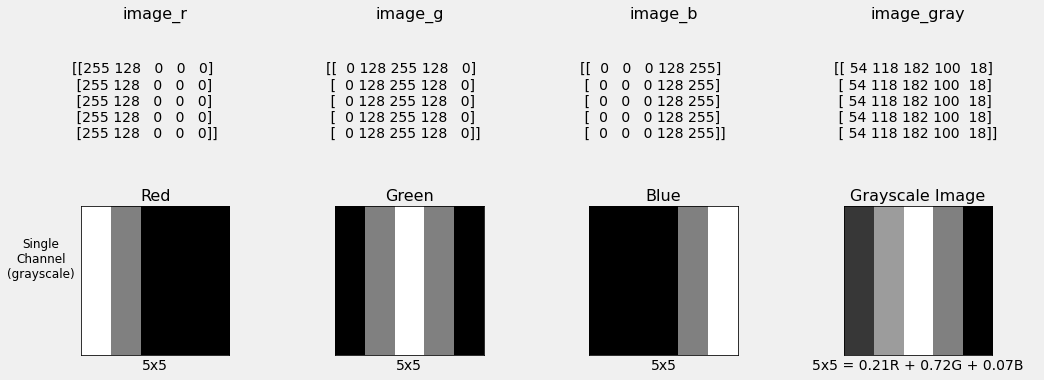

In [9]:
# Let’s see what the matrices above represent
fig = image_channels(image_r, image_g, image_b, None, image_gray, rows=(0, 1))

In [10]:
# we only need to stack the three images representing the three colors, each image becoming a channel
image_rgb = np.stack([image_r, image_g, image_b], axis=2)

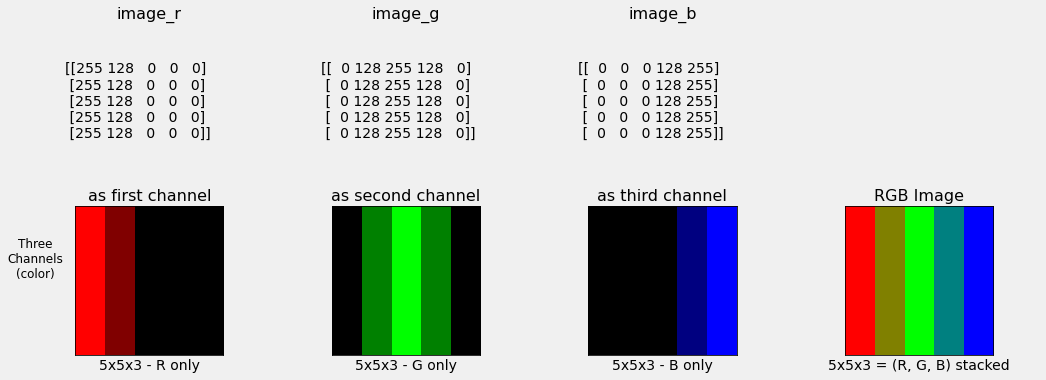

In [11]:
# Let’s see what those same matrices represent
fig = image_channels(image_r, image_g, image_b, image_rgb, image_gray, rows=(0, 2))

###Image Shape

Our dataset generates images following the PyTorch format; that is, NCHW.

In [12]:
# What’s the shape of our dataset
images.shape

(300, 1, 5, 5)

In [13]:
# Let’s take a closer look at one image
example = images[7]
example

array([[[  0, 255,   0,   0,   0],
        [  0,   0, 255,   0,   0],
        [  0,   0,   0, 255,   0],
        [  0,   0,   0,   0, 255],
        [  0,   0,   0,   0,   0]]], dtype=uint8)

What would an image in the HWC (PIL image format) look like?

We can transpose
the first dimension to become the last using Numpy's `transpose()`:

In [14]:
example_hwc = np.transpose(example, (1, 2, 0))
example_hwc.shape

(5, 5, 1)

In [15]:
example_hwc

array([[[  0],
        [255],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [255],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [255],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [255]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0]]], dtype=uint8)

##Torchvision